In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np
import joblib

import statsmodels.api as sm

from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [62]:
warnings.filterwarnings('ignore')

In [63]:
main_df = pd.read_csv('../data/raw/sales.csv')
main_df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [64]:
print(main_df.info())
print(main_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None
             sales
count   366.000000
mean    524.963968
std     275.089698
min      53.803211
25%     290.186822
50%     520.699468
75%     763.289263
max    1000.482785


<h4>Procesar datos</h4>

In [65]:
print(main_df.isnull().sum())
main_df = main_df.dropna()

date     0
sales    0
dtype: int64


In [66]:
print(main_df.duplicated().sum())
main_df = main_df.drop_duplicates()

0


In [67]:
main_df['date'] = pd.to_datetime(main_df['date'])
main_df.set_index('date', inplace=True)

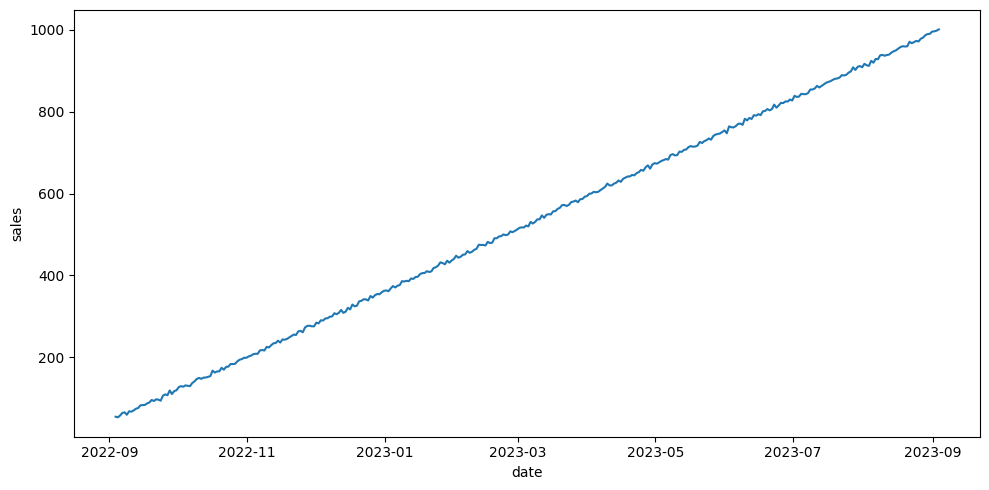

In [68]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = main_df['sales'])
plt.tight_layout()

plt.show()

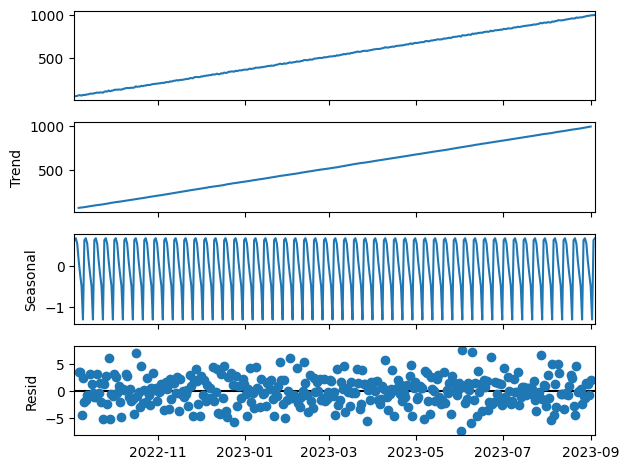

In [69]:
decomposition = sm.tsa.seasonal_decompose(main_df, model='additive')

decomposition.plot()
plt.show()

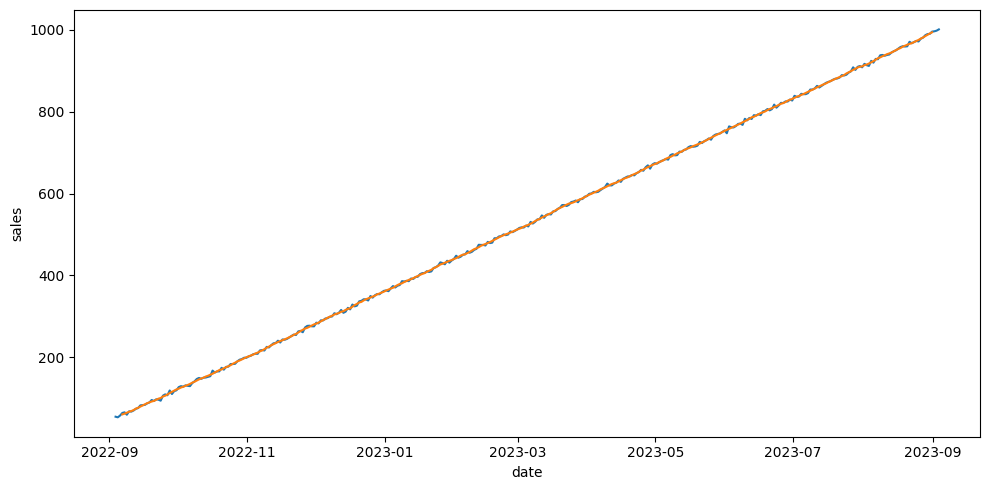

In [70]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = main_df['sales'])
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

In [71]:
result = adfuller(main_df)
print('Estadístico ADF:', result[0])
print('Valor p:', result[1])

if result[1] < 0.05:
    print("La serie es estacionaria.")
else:
    print("La serie no es estacionaria.")


Estadístico ADF: 0.545414193706378
Valor p: 0.9861899815311064
La serie no es estacionaria.


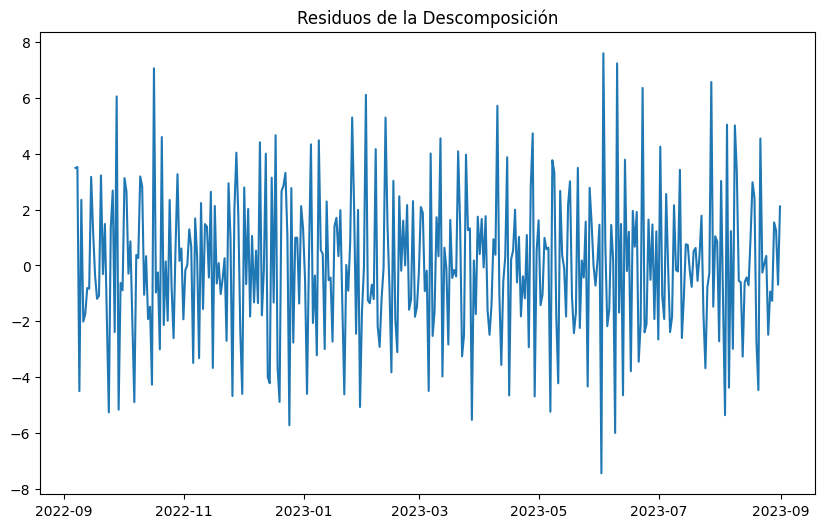

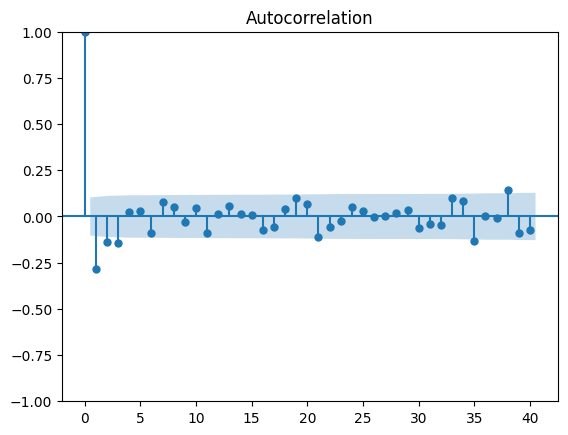

In [72]:
plt.figure(figsize=(10,6))
plt.plot(decomposition.resid)
plt.title('Residuos de la Descomposición')
plt.show()

plot_acf(decomposition.resid.dropna(), lags=40)
plt.show()

- Tensor: Días
- Tendencia: Creciente
- Estacionaria: No
- Variabilidad o ruido: Sí

<h4>ARIMA</h4>

In [73]:
train_size = int(len(main_df) * 0.8)
train, test = main_df[:train_size], main_df[train_size:]

In [74]:
model = auto_arima(main_df, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1847.127, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1972.853, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1844.670, Time=0.87 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1843.184, Time=0.44 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=0.81 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1843.586, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1841.532, Time=0.37 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1843.435, Time=1.36 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=1.10 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1839.552, Time=0.21 sec
 ARIMA(1,1,1)(1,0,0)[12] inte

In [75]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Thu, 19 Dec 2024   AIC                           1839.552
Time:                        22:26:56   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
forecast = model.predict(10)
forecast

2023-09-04 17:10:08.079328    1002.158148
2023-09-05 17:10:08.079328    1004.831669
2023-09-06 17:10:08.079328    1007.423289
2023-09-07 17:10:08.079328    1010.021630
2023-09-08 17:10:08.079328    1012.619419
2023-09-09 17:10:08.079328    1015.217254
2023-09-10 17:10:08.079328    1017.815084
2023-09-11 17:10:08.079328    1020.412915
2023-09-12 17:10:08.079328    1023.010746
2023-09-13 17:10:08.079328    1025.608577
Freq: D, dtype: float64

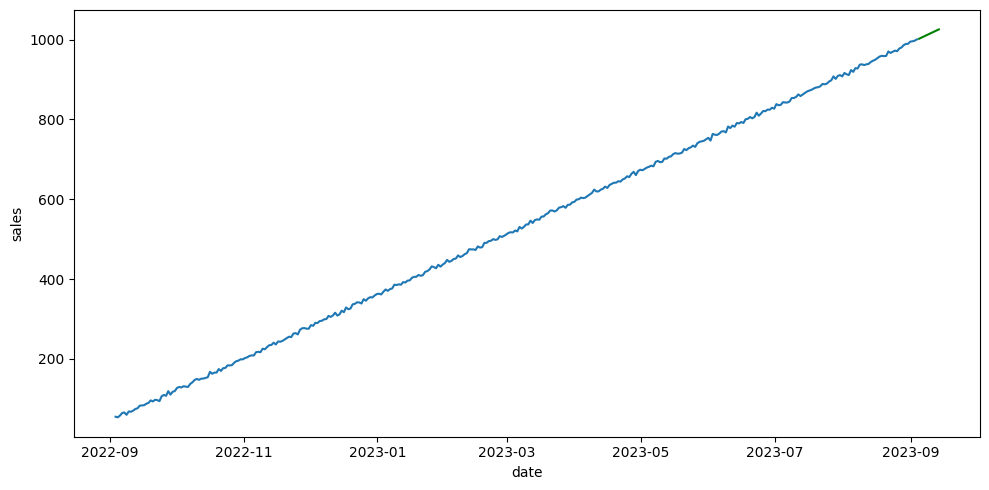

In [77]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = main_df['sales'])
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

In [78]:
print(len(test))
print(len(forecast))

74
10


In [79]:
forecast = model.predict(n_periods=len(test))

In [80]:
rmse = np.sqrt(mean_squared_error(test, forecast))

mae = mean_absolute_error(test, forecast)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 192.46373279399893
MAE: 192.44367869283192


<h4>Guardar modelo</h4>

In [81]:
joblib.dump(model, 'model.pkl')

['model.pkl']